# Estimating the Noise Level Challenge

The purpose of this challenge is to estimate the noise level on data that did not report error bars.

Check Sec. 3.2 in: http://www.stat.columbia.edu/~gelman/book/ for how this is implemented in the likelihood and prior.

Bellow is an adaptation of what we used in the "Practical Example", but missing the changes needed for the likelihood and prior.

Your task is to:

- Modify the likelihood and prior accordignly
- Perform the Metropolis sampling and plot the posteriors including the one for $\sigma$.

In [38]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import scipy

#Some pretty colors I like
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [39]:
# Define the true function
# We will not provide the true parameters, it is up to you to find the values!


In [40]:
#Generating the data and using a fixed seed to reproduce results


data_A_x=np.array([0.5,0.6,0.7,0.75,0.8,0.9,1.1,1.2,1.5,1.7,2.0])


data_A_y =np.array([1.29899102, 1.54700909, 1.51518996, 1.15977   , 1.47009939,
       1.58539306, 2.07189646, 2.2291422 , 2.30052051, 2.590777  ,
       3.17294916])


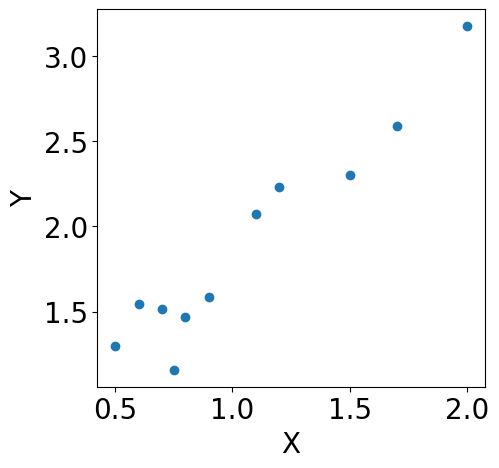

In [41]:
# Plot the data with error bars
fig, ax = plt.subplots(figsize=(5,5),dpi=100)
ax.errorbar(data_A_x, data_A_y, fmt='o', linewidth=2,capsize=7,label='Data [95% Errors]',color=colors[0])



# plt.legend(fontsize=15,frameon=True, edgecolor='black')


ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y',fontsize=20)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.show()


<font size="5">
The model we will use to fit to this data set is:
    
    

$f(x,\alpha) = \alpha_1+\alpha_2x$

In [42]:
def model_A(x,params):
    return params[0]+params[1]*x

Below you will have to modify the likelihood and prior functions to take the noise $\sigma$ as a new parameter to be estimated. 
Check Sec. 3.2 in: http://www.stat.columbia.edu/~gelman/book/

In [8]:
###########   sigmas should not be an argument anymore, but a parameter!    ############


# Define the likelihood function for given errors sigma
def likelihood(params,arguments):
#Assumed format for data=[xvals,yvals]
    data, model, sigmas = arguments
    likelihood_log_val=0

    for i in range(len(data[0])):
        likelihood_log_val=likelihood_log_val-1/2*((data[1][i] - model(data[0][i],params)) / sigmas[i])**2\
        -np.log(2*np.pi*sigmas[i]**2)/2
      
        
    return np.exp(likelihood_log_val)

# Define the prior function
def prior_model_A(params_vals,arguments):
    params0,params0_Cov_Inv_matrix=arguments
    mu=np.array(params_vals)-np.array(params0)
    params_size=len(params_vals)
    return (2*np.pi)**(-params_size/2)*np.linalg.det(params0_Cov_Inv_matrix)**(-1)*np.exp(-np.dot(mu,np.dot(params0_Cov_Inv_matrix,mu))/2)



In [9]:
# Define the Metropolis algorithm
def metropolis(data,sigma, prior,prior_arguments, likelihood,model,\
               num_iterations, step_size):
#     step_size should be a list the size of the parameters of the model
    likelihood_arguments=[data, model, sigma]
    initial_parameters=prior_arguments[0]
    #thermalizing
    burn_samples=1000
    # Set the initial state of the chain
    params_current=initial_parameters
    params_list=[]
    posterior_list=[]
    
    acceptance_times=0
    
    cov_step_size=np.diag(step_size)**2
    
    posterior_current=(likelihood(params_current,likelihood_arguments))*(prior(params_current,\
                                                                               prior_arguments))
    
    # Run the Metropolis-Hastings algorithm for burning
    for i in range(burn_samples):
        # Propose a new state for the chain
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)
        
        posterior_proposed=(likelihood(params_proposed,likelihood_arguments))*(prior(params_proposed,\
                                                                               prior_arguments))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, posterior_proposed / posterior_current)

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            posterior_current=posterior_proposed


    for i in range(num_iterations):
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)
        
        posterior_proposed=(likelihood(params_proposed,likelihood_arguments))*\
        (prior(params_proposed,prior_arguments))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, posterior_proposed / posterior_current)

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            posterior_current=posterior_proposed
            acceptance_times=acceptance_times+1

        # Store the current state
        params_list.append(params_current)
        posterior_list.append(posterior_current)
        
    
    #Rule of thumb acceptance is around 50%. 
    #You could plot the accuracy of the estimations as a function of this rate, that would be interesting to see. 
    print(acceptance_times/num_iterations*100,"%")
    
    return(np.array(params_list),np.array(posterior_list),\
           acceptance_times/num_iterations*100)



In [10]:
np.random.seed(142857)

#Setting up the prior
prior_arguments_A=[[0,1],np.linalg.inv(np.diag([2**2,2**2]))]

#Doing the Metropolis sampling for 100000 values
results_A=metropolis([data_A_x,data_A_y],data_A_errors, prior_model_A,\
                         prior_arguments_A, likelihood,model_A,100000, [0.2,0.2])
all_chains =results_A[0]

40.175 %


Lets plot the parameters we visited from the Metropolis algorithm using the corner package in python

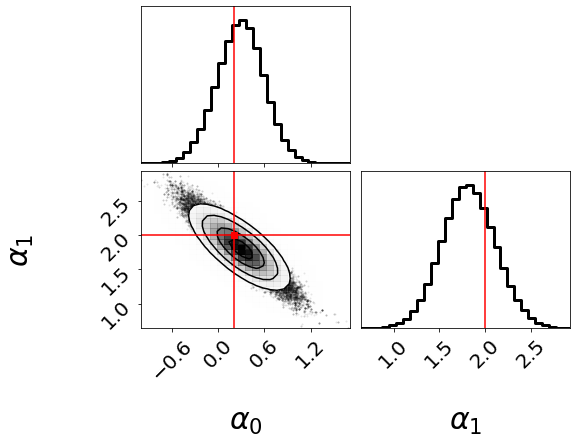

In [12]:

figure = corner.corner(all_chains,
    labels=[r'$\alpha_0$',r'$\alpha_1$'],
    labelpad=0.2,
                       bins=30,
    label_kwargs={"fontsize":30},
                      hist_kwargs= {"linewidth":3},
    quantiles=None
#                        #This "truth" value shows what we used to generate the data
#                        ,truths=[0.2,2], truth_color='r'
                       ,
    smooth=(1.7)
                       ,
    smooth1d=1.0
                      )


width = 8
height = 6
figure.set_size_inches(width, height)
plt.rc('xtick', labelsize=15)    
plt.rc('ytick', labelsize=15)



If all went well, you should now have three parameters in the corner plot: slope and intercept, and the noise level $\sigma$